# Multi-armed bandits

The objective of this lab session is to test the performance of some usual bandit algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

## Algorithms

There are $k$ possible actions, $a \in \{ 0, 1,...,k - 1\}$. 

We consider the following algorithms:
* $\varepsilon$-greedy
* adaptive greedy
* UCB
* Thompson sampling

Each algorithm returns an action $a$ based on the following inputs:

| Variable   |      Type      |  Description |
|:---|:---|:---|
| `nb_tries` |  1D array of int of size `k` | number of tries of each action so far |
| `cum_rewards` |    1D array of float of size `k`    |   cumulative reward of each action so far |
| `t` | integer (optional) |    current time |
| `param` | mixed |    parameter of the algorithm |


***

**To do:**
* Code the UCB algorithm. 
* Observe the behaviour of the algorithms, for different parameters.
* Test the principle of "optimism in face of uncertainty" on the greedy policies.

**Hint:** Use the `simple_test` function to test the behaviour of the algorithms for binary rewards.

***

In [2]:
def eps_greedy(nb_tries, cum_rewards, param):
    if param == None:
        eps = 0.1
    else:
        eps = float(param)
    k = np.shape(nb_tries)[0]
    if np.sum(nb_tries) == 0 or np.random.random() < eps:
        return np.random.randint(k)
    else:
        index = np.where(nb_tries > 0)[0]
        return index[np.argmax(cum_rewards[index] / nb_tries[index])]

In [3]:
def adaptive_greedy(nb_tries, cum_rewards, param):
    if param == None:
        c = 1.
    else:
        c = float(param)
    k = np.shape(nb_tries)[0]
    t = np.sum(nb_tries)
    if np.sum(nb_tries) == 0 or np.random.random() < c / (c + t):
        return np.random.randint(k)
    else:
        index = np.where(nb_tries > 0)[0]
        return index[np.argmax(cum_rewards[index] / nb_tries[index])]

In [4]:
def ucb(nb_tries, cum_rewards, param):
    if param == None:
        c = 1. 
    else:
        c = float(param)
    # to be completed
    #Q(a) = R(a)/N(a) R: cumulative reward of action a / N: number of selections of action a
    t = np.sum(nb_tries)
    index = []
    for i in range(len(nb_tries)):
        if nb_tries[i] == 0:
            index.append(i)
            return(random.choice(index))
    a = np.argmax(cum_rewards/nb_tries + c*np.sqrt(np.log(t)/nb_tries))
    return a

In [5]:
def thompson(nb_tries, cum_rewards, param):
    k = np.shape(nb_tries)[0]
    if param == "beta":
        # Beta prior
        try:
            samples = np.random.beta(cum_rewards + 1, nb_tries - cum_rewards + 1)
        except:
            samples = np.random.random(k)
    else:
        # Normal prior
        samples = np.random.normal(cum_rewards / (nb_tries + 1), 1. / (nb_tries + 1))
    return np.argmax(samples)

## Test

In [6]:
def get_action(algo, nb_tries, cum_rewards, param = None):
    if algo == "eps_greedy":
        return eps_greedy(nb_tries, cum_rewards, param)
    elif algo == "adaptive_greedy":
        return adaptive_greedy(nb_tries, cum_rewards, param)
    elif algo == "ucb":
        return ucb(nb_tries, cum_rewards, param)
    elif algo == "thompson":
        return thompson(nb_tries, cum_rewards, param)

In [7]:
def get_bernoulli_reward(a, model_param):
    return float(np.random.random() < model_param[a])

In [8]:
def simple_test(algo, model_param = [0.1, 0.6, 0.3], time_horizon = 20, param = None):
    k = len(model_param)
    nb_tries = np.zeros(k, int)
    cum_rewards = np.zeros(k, float)
    print ("action -> reward")
    for t in range(time_horizon):
        a = get_action(algo, nb_tries, cum_rewards, param)
        r = get_bernoulli_reward(a, model_param)
        print(str(a) + " -> " + str(int(r)))
        nb_tries[a] += 1
        cum_rewards[a] += r
    index = np.where(nb_tries > 0)[0]
    best_action = index[np.argmax(cum_rewards[index] / nb_tries[index])]
    print("Best action (estimation) = ", best_action)
    print("Average reward of this action = ", cum_rewards[best_action] / nb_tries[best_action])

In [9]:
algos = ["eps_greedy", "adaptive_greedy", "ucb", "thompson"]

In [10]:
algo = algos[2]
simple_test(algo)

action -> reward
0 -> 0
1 -> 1
2 -> 0
1 -> 0
1 -> 1
1 -> 0
0 -> 0
2 -> 0
1 -> 1
1 -> 1
1 -> 1
1 -> 0
1 -> 1
1 -> 1
1 -> 0
0 -> 0
2 -> 0
1 -> 1
1 -> 1
1 -> 1
Best action (estimation) =  1
Average reward of this action =  0.7142857142857143


## Regret and precision

We now compare the performance of the algorithms in terms of **regret** and **precision**.

We consider two models: Bernoulli rewards and normal rewards. 

In [11]:
def get_reward(a, model, model_param):
    if model == "bernoulli":
        return float(np.random.random() < model_param[a])
    elif model == "normal":
        return np.random.normal(*model_param[a])

In [12]:
def simulate(model, model_param, time_horizon, algo, param = None):
    k = len(model_param)
    nb_tries = np.zeros(k, int)
    cum_rewards = np.zeros(k, float)
    action_seq = []
    reward_seq = []
    for t in range(time_horizon):
        a = get_action(algo, nb_tries, cum_rewards, param)
        r = get_reward(a, model, model_param)
        nb_tries[a] += 1
        cum_rewards[a] += r
        action_seq.append(a)
        reward_seq.append(r)
    return action_seq, reward_seq

In [13]:
# Bernoulli rewards
model = "bernoulli"
model_param = [0.1, 0.6, 0.3]
time_horizon = 20
algo = algos[1]
action_seq, reward_seq = simulate(model, model_param, time_horizon, algo)
print(action_seq)
print(reward_seq)

[0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
# Normal rewards
model = "normal"
model_param = [(2,1), (2.5,1)]
action_seq, reward_seq = simulate(model, model_param, time_horizon, algo)
print(action_seq)
print(reward_seq)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
[3.576950315367807, 2.5489694191209287, 2.3728297925007604, 1.8498641193520209, 2.113203606080373, 2.5487875704395138, 2.723363683923412, 1.3938249753418979, 3.2124468045192343, 2.7921303306519216, 3.529343127593463, 3.1370542217783273, 2.2932910187549536, 4.418755528943768, 2.228074005564082, 2.9633890481260785, 1.1378497868676138, 1.8456246987107758, 2.4624456856185493, 3.038330800435306]


***

**To do:**
* Write the function `get_metrics` that returns the regret and precision throughout the run of the algorithm.
* Observe the behaviour of each algorithm over independent runs, for both models and different instances of the model.
* How do you explain that the regret can be negative?
* Test the impact of the prior used by Thompson sampling

**Note:** The `get_best_action` function returns the list of best actions and the corresponding expected reward.

***

In [15]:
def get_best_action(model, model_param):
    if model == "bernoulli":
        best_reward = np.max(model_param)
        best_actions = list(np.where(model_param == best_reward)[0])
    elif model == "normal":
        means = [model_param[a][0] for a in range(len(model_param))]
        best_reward = np.max(means)
        best_actions = list(np.where(means == best_reward)[0])
    return best_actions, best_reward

In [16]:
def get_metrics(action_seq, reward_seq, best_actions, best_reward):
    time_horizon = len(action_seq)
    regret = np.zeros(time_horizon, float)
    precision = np.zeros(time_horizon, float)
    # to be completed
    for T in range(1,time_horizon):
        regret[T] = best_reward*T
        precision_sum = 0
        for t in range(1,T): 
            regret[T] -= reward_seq[t]
            if action_seq[t] == best_actions:
                precision_sum += 1
        precision[T] = precision_sum/T
    return regret, precision

In [17]:
def show_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Regret')
    ax1.plot(range(time_horizon),metrics[0], color = 'b')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Precision')
    ax2.set_ylim(-0.02,1.02)
    ax2.plot(range(time_horizon),metrics[1], color = 'b')
    plt.show()

In [18]:
time_horizon = 10000
model = "bernoulli"
model_param = [0.2, 0.5]

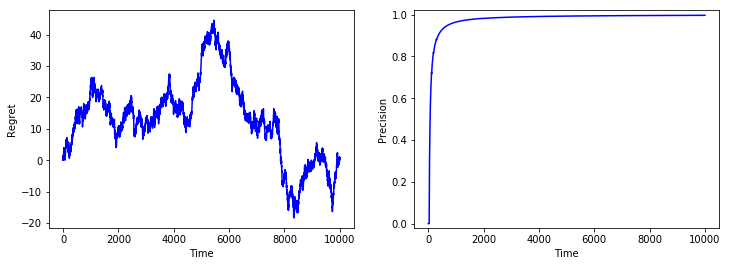

In [27]:
algo = algos[1]
results = simulate(model, model_param, time_horizon,  algo)
metrics = get_metrics(*results, *get_best_action(model, model_param))
show_metrics(metrics)

## Statistics

Finally, we provide some statistics on the performance of each algorithm for different time horizons.

***

**To do:**
* Compare the performance of the algorithms.
* What algorithm would you recommand for a time horizon $T = 1000$?

***

In [23]:
def get_stats(nb_samples, time_periods, model, model_param, algo, param = None):
    time_horizon = max(time_periods)
    norm_regret_samples = [[] for t in time_periods]
    precision_samples = [[] for t in time_periods]
    for s in range(nb_samples):
        results = simulate(model, model_param, time_horizon, algo, param)
        regret, precision = get_metrics(*results, *get_best_action(model, model_param))
        for i,t in enumerate(time_periods):
            norm_regret_samples[i].append(regret[t - 1] / t)
            precision_samples[i].append(precision[t - 1])
    return norm_regret_samples, precision_samples

In [24]:
def show_stats(time_periods, stats):
    meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='r')
    medianprops = dict(linestyle='-', linewidth=2.5, color = 'b')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.boxplot(stats[0], positions = range(len(time_periods)), showfliers = False, showmeans = True, meanprops = meanprops, medianprops = medianprops)
    ax1.axhline(linestyle = '--', color = 'r')
    ax1.set_xticklabels(time_periods)
    ax1.set_xlabel('Time horizon')
    ax1.set_ylabel('Normalized regret')
    ax2.boxplot(stats[1], positions = range(len(time_periods)), showfliers = False, showmeans = True, meanprops = meanprops, medianprops = medianprops)
    ax2.set_ylim(-0.02,1.02)
    ax2.axhline(y = 1, linestyle = '--', color = 'r')
    ax2.set_xticklabels(time_periods)
    ax2.set_xlabel('Time horizon')
    ax2.set_ylabel('Precision')
    plt.show()

In [25]:
time_periods = [100,1000,5000]
nb_samples = 100
model = "bernoulli"
model_param = [0.1, 0.2]
algo = algos[3]
stats = get_stats(nb_samples, time_periods, model, model_param, algo)

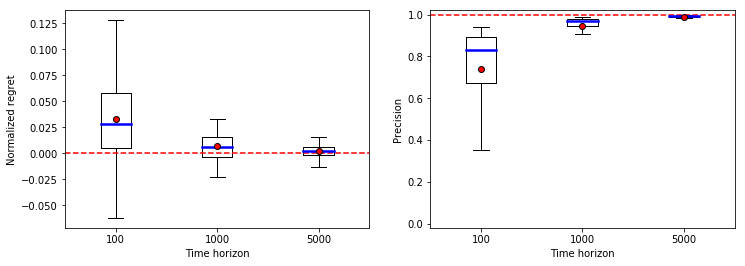

In [26]:
show_stats(time_periods, stats)